In [1]:
!pip install opencv-python numpy

In [2]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
import imutils

In [3]:
def image_preprocess(img):
    image = img.copy()
    ratio = image.shape[0] / 500.0
    image = imutils.resize(image, height = 500)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    edged = cv2.Canny(gray, 50, 200)

    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1)
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

    fig.add_subplot(1,2,2)
    plt.title("Edged Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(edged)
    plt.show()

    return image, edged, ratio


In [4]:
def contours(image, edged):
    cnts, heirarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]


    for c in cnts:

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            screenCnt = approx
            break


    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    fig=plt.figure(figsize=(7,7))
    plt.title("Contour Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

    return screenCnt

In [5]:
def order_points(pts):


    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [6]:
def four_point_transform(image, pts):


    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))


    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))


    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]], dtype = "float32")


    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [7]:
def final_scanned(screenCnt, image, ratio):
    orig = image.copy()
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    # convert the warped image to grayscale, then threshold it to give it that 'black and white' paper effect

    #warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    #T = threshold_local(warped, 11, offset = 10, method = "gaussian")
    #warped = (warped > T).astype("uint8") * 255

    # show the original and scanned images


    #cv2.imshow("Original", imutils.resize(orig, height = 650))
    #cv2.imshow("Scanned", imutils.resize(warped, height = 650))
    #cv2.waitKey(0)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

    fig=plt.figure(figsize=(15,15))
    fig.add_subplot(1,2,1)
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(orig)

    fig.add_subplot(1,2,2)
    plt.title("Scanned Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(warped)
    plt.show()

In [48]:
img = cv2.imread('/content/1 (1).jpg')

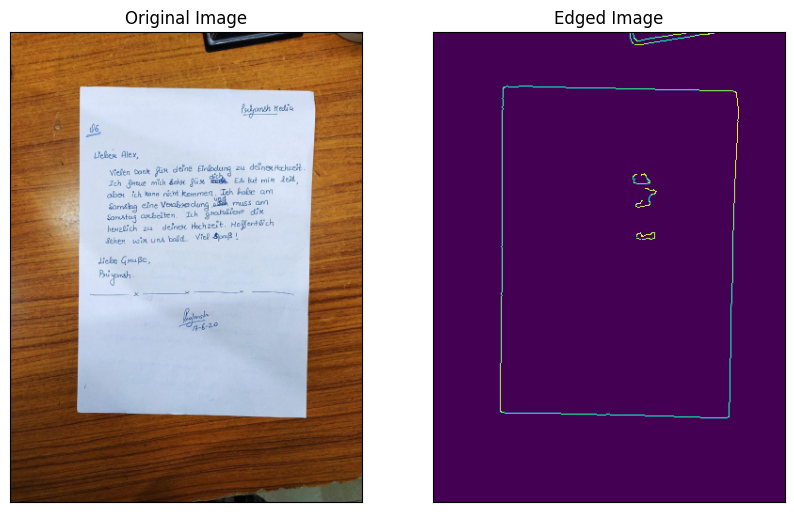

In [49]:
image, edged, ratio = image_preprocess(img)

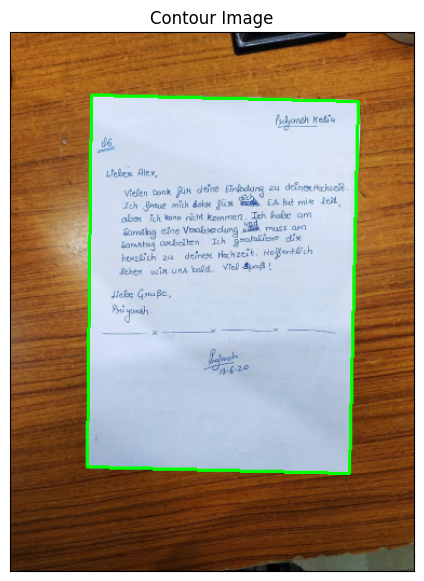

In [50]:
screenCnt = contours(image, edged)

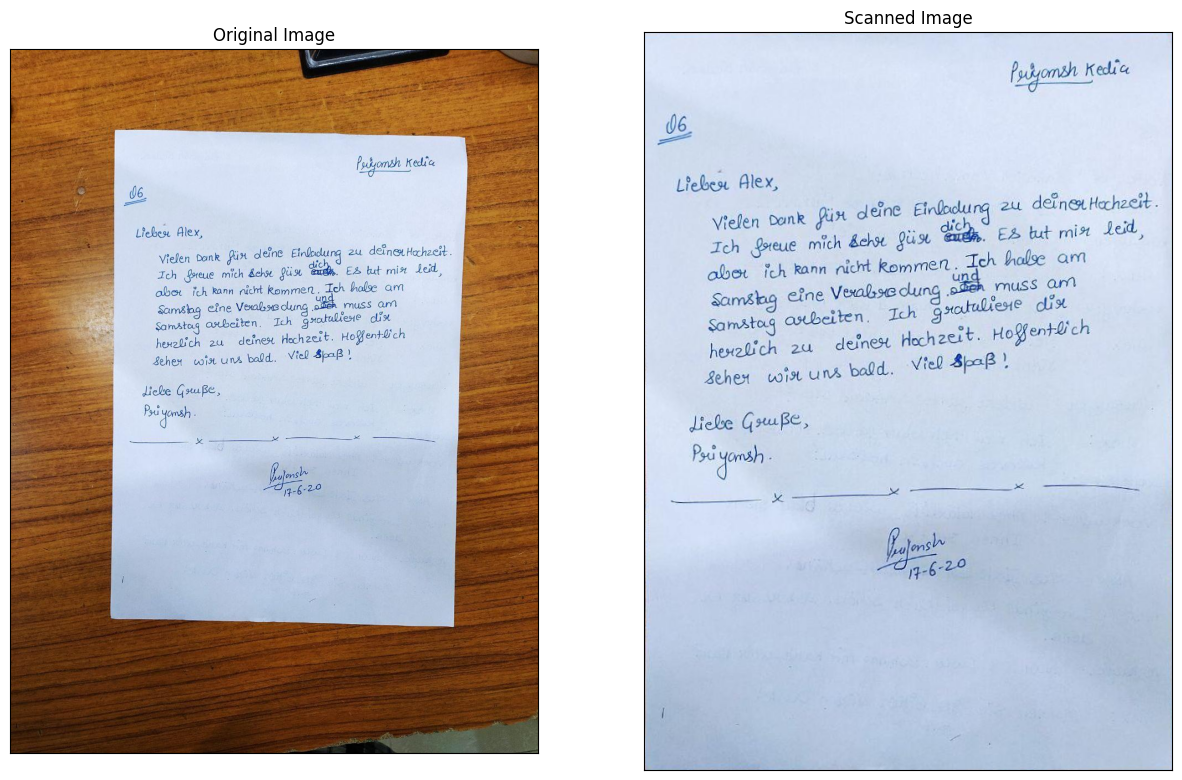

In [51]:
final_scanned(screenCnt, img, ratio)